In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import autorootcwd
import os

import torch

from src.utils import get_torch_device, id_to_chord_map, get_chord_annotation, HOP_LENGTH, SR
from src.models.crnn import CRNN

frame_to_secs = lambda x: round(x * (HOP_LENGTH / SR), 2)

def chord_frames_to_sequence(pred_classes):
    """
    Given a list of chord IDs (one per frame), returns a list of
    (chord, start_time_sec, end_time_sec) tuples, where:
      - start_time_sec = frame_to_secs(start_frame)
      - end_time_sec   = frame_to_secs(end_frame)
    """

    chords = []
    start_frame = 0
    n_frames = len(pred_classes)

    # Edge case: if no frames, return empty
    if n_frames == 0:
        return chords

    # Iterate until the second-to-last frame
    for i in range(n_frames - 1):
        c = pred_classes[i]
        # If the chord changes at the next frame, or we are at the last iteration:
        if c != pred_classes[i + 1]:
            # The chord c spanned from start_frame..i (inclusive).
            # We'll consider the chord region to end right after frame i => i+1
            chords.append(
                (c, frame_to_secs(start_frame), frame_to_secs(i + 1))
            )
            # Next chord region starts at i+1
            start_frame = i + 1

    # Handle the final chord, spanning from start_frame..(n_frames)
    last_chord = pred_classes[-1]
    chords.append(
        (last_chord, frame_to_secs(start_frame), frame_to_secs(n_frames))
    )

    return chords

def get_model(
    exp_dir="final_experiments/synthetic_data/",
    # exp_dir="hparams_random/segment_length_28_layers_1_hidden_size_201",
    hmm=True,
    hmm_alpha=0.2,
    device=None,
):
    if device is None:
        device = get_torch_device()
    state_dict = torch.load(
        f"./results/{exp_dir}/best_model.pth", map_location=device, weights_only=True
    )
    model = CRNN(hmm_smoothing=hmm, hmm_alpha=hmm_alpha, structured_loss=True)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    return model

In [101]:
model = get_model()
# model_smooth = get_model(hmm=True, hmm_alpha=0.2)
device = get_torch_device()
DIR = 'data/processed'
filename = "queen_dontstopmenow"
cqt = torch.load(f"{DIR}/cache/4096/cqts/{filename}.pt", weights_only=True) 

In [102]:
preds = model.predict(cqt.unsqueeze(0).to(device)).squeeze()
# preds_smooth = model_smooth.predict(cqt.unsqueeze(0).to(device)).squeeze()
true_chords = get_chord_annotation(filename, frame_length=HOP_LENGTH/SR)

In [103]:
# overall acc
min_length = min(len(preds), len(true_chords))
preds = preds[:min_length]
true_chords = true_chords[:min_length]
mask = torch.logical_and(true_chords != -1, true_chords != 1)
overall_acc = (preds[mask] == true_chords[mask]).float().mean()
overall_acc

tensor(0.5627)

In [104]:
from src.eval import evaluate_model
from src.data.dataset import FullChordDataset

ds = FullChordDataset(filenames=[filename], dev_mode=True)
m = evaluate_model(model, ds)
m

Evaluating model...


Predicting:   0%|          | 0/1 [00:00<?, ?it/s]

Class-wise metrics:  33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]/Users/pierrelardet/.pyenv/versions/UG4Diss/lib/python3.8/site-packages/mir_eval/chord.py:700: UserWarning: No reference chords were comparable to estimated chords, returning 0.
  warnings.warn(
Class-wise metrics: 100%|██████████| 6/6 [00:00<00:00, 31.23it/s]


{'mean': {'root': 88.38684554645774,
  'mirex': 86.36056189807671,
  'third': 87.33324965887097,
  'seventh': 56.99845757214908,
  'majmin': 87.14657933087507,
  'acc': 56.17066853107207},
 'median': {'root': 88.38684554645774,
  'mirex': 86.36056189807671,
  'third': 87.33324965887097,
  'seventh': 56.99845757214908,
  'majmin': 87.14657933087507,
  'acc': 56.17066853107207},
 'std': {'root': 0.0,
  'mirex': 0.0,
  'third': 0.0,
  'seventh': 0.0,
  'majmin': 0.0,
  'acc': 0.0},
 'boostrap-stde': {'root': 1.4210854715202004e-14,
  'mirex': 1.4210854715202004e-14,
  'third': 1.4210854715202004e-14,
  'seventh': 2.1316282072803006e-14,
  'majmin': 0.0,
  'acc': 1.4210854715202004e-14},
 'bootstrap-95ci': {'root': (88.38684554645774, 88.38684554645774),
  'mirex': (86.36056189807671, 86.36056189807671),
  'third': (87.33324965887097, 87.33324965887097),
  'seventh': (56.99845757214908, 56.99845757214908),
  'majmin': (87.14657933087507, 87.14657933087507),
  'acc': (56.17066853107207, 56.

In [105]:
def to_seq(seq):
    if torch.is_tensor(seq):
        seq = seq.squeeze().cpu().numpy()
    # Convert to chord ids
    seq_chords = [id_to_chord_map[c] for c in seq]
    # Convert to chord sequence
    seq = chord_frames_to_sequence(seq_chords)
    return seq

preds_seq = to_seq(preds)
# preds_smooth_seq = to_seq(preds_smooth)
true_chords_seq = to_seq(true_chords)

# preds_seq, true_chords_seq

### Make it Pretty!

In [106]:
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorsys
import random
from matplotlib.ticker import FuncFormatter

from src.utils import chord_to_id, id_to_chord, chord_to_id_map

##############################################################################
# 1) Utility to convert from large-vocab ID to small-vocab ID
##############################################################################
@lru_cache(maxsize=None)
def large_to_small_vocab_id(ch_id: int) -> int:
    """
    Converts a large vocabulary chord id to a small vocabulary chord id.
    """
    chord = id_to_chord(ch_id, use_small_vocab=False)
    return chord_to_id(chord, use_small_vocab=True)

##############################################################################
# 2) Helper function to clip chord intervals to [start_time, end_time],
#    but do NOT shift times (i.e., no rebase).
##############################################################################
def slice_chords_no_rebase(chords, start_time, end_time):
    """
    chords: list of (chord_id, chord_abs_start)

    Convert each chord to (chord_id, chord_abs_start, chord_abs_end),
    and clip to [start_time, end_time], but do NOT shift times to zero.
    """
    intervals = []
    for i, (cid, cstart) in enumerate(chords):
        # End time from next chord or +2 if last
        if i < len(chords) - 1:
            cend = chords[i + 1][1]
        else:
            cend = cstart + 2.0

        # Overlap with [start_time, end_time]?
        if cend >= start_time and cstart <= end_time:
            clipped_start = max(cstart, start_time)
            clipped_end   = min(cend, end_time)
            if clipped_end > clipped_start:
                intervals.append((cid, clipped_start, clipped_end))
    return intervals

def slice_intervals_for_window(intervals, window_start, window_end):
    """
    intervals: list of (chord_id, chord_abs_start, chord_abs_end)
    Returns only the portion of each interval overlapping [window_start, window_end].
    """
    clipped = []
    for (cid, st, en) in intervals:
        # Check overlap
        if en >= window_start and st <= window_end:
            cst = max(st, window_start)
            cen = min(en, window_end)
            if cen > cst:
                clipped.append((cid, cst, cen))
    return clipped

##############################################################################
# 3) Main plotting function
##############################################################################
def plot_chord_block(
    chord_sequences_dict,
    window=None,
    title=None,
    width_per_second=0.4,
    draw_chord_change_lines=True,
    save_as=None,
    height_per_track=1.0,
    fsize=16,
    title_pad=15,
    seed=0
):
    """
    chord_sequences_dict: { "True": [tensor-or-list-of-frame-chords], "Predicted": [...], ... }
      - Each entry is a sequence of per-frame chord IDs (or a torch tensor).
    window: (start_t, end_t) to clip & display. We do NOT shift times to zero.
    title: optional plot title
    width_per_second: figure width scale factor per second in the timeline
    draw_chord_change_lines: whether to draw vertical lines for chord changes in the FIRST sequence
    save_as: optional file name prefix to save PNG
    seed: random seed to shuffle the color palette
    """

    ###########################################################################
    # A) Convert frame-level chord data -> (cid, start_sec, end_sec) intervals
    ###########################################################################
    new_chord_sequences_dict = {}
    for label, seq in chord_sequences_dict.items():
        # 1) If seq is a torch tensor, convert to numpy
        if torch.is_tensor(seq):
            seq = seq.squeeze().cpu().numpy()

        # 2) Convert numeric chord IDs to chord *names* (or pass as-is, depending on your code).
        #    For example, if your 'seq' is already small or large chord IDs, you might do:
        #    seq_chords = [id_to_chord_map[c] for c in seq]
        #    But let's assume we want to keep them as numeric IDs for chord_frames_to_sequence:
        seq_chords = seq  # if you want to keep them numeric, directly

        # 3) Convert frames -> intervals with REAL end times
        seq_intervals = chord_frames_to_sequence(seq_chords)

        new_chord_sequences_dict[label] = seq_intervals

    chord_sequences_dict = new_chord_sequences_dict

    ###########################################################################
    # B) Create color palette (for small-vocab chord IDs)
    ###########################################################################
    NUM_SMALL_CHORDS = 26
    perm = list(range(NUM_SMALL_CHORDS))
    random.seed(seed)
    random.shuffle(perm)

    colors_26 = []
    for i in range(NUM_SMALL_CHORDS):
        j = perm[i]
        hue = j / NUM_SMALL_CHORDS
        s = 0.5
        v = 1.0
        r, g, b = colorsys.hsv_to_rgb(hue, s, v)
        # 50% alpha face color
        colors_26.append((r, g, b, 0.5))

    def get_small_vocab_color(large_id: int):
        """
        Example: Convert a 'large' chord ID to a 'small' one, then pick from colors_26.
        If you have a direct mapping, adapt accordingly.
        """
        sv_id = large_to_small_vocab_id(large_id)
        return colors_26[sv_id]

    ###########################################################################
    # C) Determine x_min, x_max from the intervals (unless 'window' is given)
    ###########################################################################
    # The first sequence is used for chord-change lines, so let's identify it
    labels_in_order = list(chord_sequences_dict.keys())
    if not labels_in_order:
        print("No chord data in chord_sequences_dict.")
        return

    first_label = labels_in_order[0]
    first_seq   = chord_sequences_dict[first_label]  # each item is (cid, st, en)

    if window is not None:
        # If user provided window, trust that
        x_min, x_max = window
    else:
        # Derive from chord data
        starts_ends = []
        for intervals in chord_sequences_dict.values():
            for (cid, st, en) in intervals:
                starts_ends.append(st)
                starts_ends.append(en)
        if not starts_ends:
            print("No chord data!")
            return
        x_min = min(starts_ends)
        x_max = max(starts_ends)

    window_length = x_max - x_min
    if window_length <= 0:
        print("No valid window to display: end <= start.")
        return

    ###########################################################################
    # D) Clip each sequence of intervals to [x_min, x_max] if needed
    ###########################################################################
    tracks = []
    for label, intervals in chord_sequences_dict.items():
        if window is not None:
            clipped = slice_intervals_for_window(intervals, x_min, x_max)
        else:
            clipped = intervals
        tracks.append((label, clipped))

    ###########################################################################
    # E) Plot
    ###########################################################################
    num_tracks = len(tracks)
    fig_width  = max(1.0, width_per_second * window_length)
    fig_height = height_per_track * num_tracks + 0.5
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    def plot_chord_rectangles(chords_3col, y_base, x_left, ax, label_text=None):
        """
        chords_3col: list of (chord_id, start_sec, end_sec)
        y_base: bottom of rectangle track
        x_left: used for label placement
        """
        for (cid, st, en) in chords_3col:
            width = en - st
            color = get_small_vocab_color(cid)
            # Draw a rectangle
            rect = Rectangle(
                (st, y_base),
                width,
                height_per_track,
                edgecolor=(0, 0, 0, 1.0),
                facecolor=color
            )
            ax.add_patch(rect)

            # Optionally label chord if wide enough
            if width >= 0.8:
                chord_name = id_to_chord_map[cid]
                ax.text(
                    st + width/2,
                    y_base + height_per_track / 2,
                    chord_name,
                    ha='center',
                    va='center'
                )

        if label_text is not None:
            ax.text(
                x_left - 0.2,
                y_base + height_per_track / 2,
                label_text,
                ha='right',
                va='center',
                style='italic'
            )

    # Plot each track from top (0) down
    for i, (label, intervals) in enumerate(tracks):
        y_base = -i * height_per_track
        plot_chord_rectangles(intervals, y_base, x_min, ax, label_text=label)

    # Optionally draw vertical lines for chord changes in the *first* sequence
    if draw_chord_change_lines:
        for (cid, st, en) in first_seq:
            # Only draw line if it falls in [x_min, x_max]
            if x_min <= st <= x_max:
                ax.axvline(st, color='black', linestyle='--', linewidth=0.8, alpha=0.8, zorder=-1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(
        -(num_tracks - 1) * height_per_track,
        height_per_track
    )


    # Format x-axis in mm:ss
    tick_start = int(np.floor(x_min / 5.0)) * 5
    tick_end   = int(np.ceil(x_max / 5.0)) * 5
    major_ticks = list(range(tick_start, tick_end + 1, 5))
    major_ticks = [t for t in major_ticks if t >= x_min and t <= x_max]
    ax.set_xticks(major_ticks)

    def format_mmss(x, pos):
        m = int(x // 60)
        s = int(x % 60)
        return f"{m}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(format_mmss))
    # Optional vertical grid lines at these ticks:
    # for t in major_ticks:
    #     ax.axvline(t, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

    # Hide y-axis ticks
    ax.set_yticks([])

    if title:
        ax.set_title(title, ha='center', pad=title_pad, fontsize=fsize)

    plt.tight_layout()

    if save_as is not None:
        plt.savefig(f'./thesis/figures/{save_as}.png', dpi=200, bbox_inches='tight')
    plt.show()


### Chords Wrapped

In [107]:
def plot_chord_block_wrapped(
    chord_sequences_dict,
    title=None,
    max_time_per_row=30.0,
    width_per_second=0.15,
    seed=0
):
    """
    chord_sequences_dict: {"TrackName": [frame-level chord IDs], ...}
       Each value can be a tensor or a list/array of chord IDs.
       The function will first convert these into a sequence of
       (chord, start_time_sec, end_time_sec) tuples.
    max_time_per_row:    how many seconds to show per row (subplot)
    width_per_second:    scaling factor for the figure width per second
    seed:                random seed for consistent color generation
    """

    # --- A) Convert frame-level chord data to (chord, start, end) intervals ---
    new_chord_sequences_dict = {}
    for label, seq in chord_sequences_dict.items():
        # If seq is a tensor, convert to numpy.
        if torch.is_tensor(seq):
            seq = seq.squeeze().cpu().numpy()
        # Convert each numeric ID to a chord name (if needed).
        # Here we assume id_to_chord_map is a dict mapping numeric IDs to chord names.
        seq_chords = [id_to_chord_map[c] for c in seq]
        # Convert frame-level data to chord intervals using the updated function.
        seq_intervals = chord_frames_to_sequence(seq_chords)
        new_chord_sequences_dict[label] = seq_intervals
        
    chord_sequences_dict = new_chord_sequences_dict

    # --- B) Determine overall min/max time from all intervals ---
    starts_ends = []
    for seq in chord_sequences_dict.values():
        for (cid, st, en) in seq:
            starts_ends.append(st)
            starts_ends.append(en)
    if not starts_ends:
        print("No chord data!")
        return
    x_min = min(starts_ends)
    x_max = max(starts_ends)
    total_time = x_max - x_min

    if total_time <= 0:
        print("Invalid timeline. x_max <= x_min.")
        return

    # --- C) Determine number of rows (chunks) needed ---
    num_rows = int(np.ceil(total_time / max_time_per_row))

    # --- D) Create color palette (26 chords) ---
    NUM_SMALL_CHORDS = 26
    perm = list(range(NUM_SMALL_CHORDS))
    random.seed(seed)
    random.shuffle(perm)
    colors_26 = []
    for i in range(NUM_SMALL_CHORDS):
        j = perm[i]
        hue = j / NUM_SMALL_CHORDS
        s = 0.5
        v = 1.0
        r, g, b = colorsys.hsv_to_rgb(hue, s, v)
        # Set a slightly transparent face color.
        colors_26.append((r, g, b, 0.6))

    def get_color(ch_id):
        # Assume large_to_small_vocab_id converts chord id to an index.
        sv_id = large_to_small_vocab_id(ch_id)
        return colors_26[sv_id]

    # --- E) Create subplots: one row per chunk ---
    num_tracks = len(chord_sequences_dict)
    fig_height = 2.0 * num_rows
    fig_width = max(5.0, width_per_second * max_time_per_row)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(fig_width, fig_height), sharex=False)

    if num_rows == 1:
        axes = [axes]  # Ensure axes is a list.

    # --- F) For each row, plot the chord intervals rebased to the row's time window ---
    for row_idx in range(num_rows):
        row_start = x_min + row_idx * max_time_per_row
        row_end   = row_start + max_time_per_row
        ax = axes[row_idx]

        # Plot each track in this row (stacked vertically)
        for i, (track_name, chord_seq) in enumerate(chord_sequences_dict.items()):
            y_base = -i

            # Clip intervals to the current row's window.
            intervals = slice_intervals_for_window(chord_seq, row_start, row_end)
            # Re-base intervals so that row_start maps to 0.
            intervals = [(cid, st - row_start, en - row_start) for (cid, st, en) in intervals]

            # Draw each chord rectangle.
            for (chord, start_s, end_s) in intervals:
                # Convert the chord (name) to an ID using your mapping.
                chord_id = chord_to_id_map[chord]
                width = end_s - start_s
                color = get_color(chord_id)

                rect = Rectangle(
                    (start_s, y_base),
                    width,
                    1.0,
                    edgecolor='black',
                    facecolor=color
                )
                ax.add_patch(rect)

                # Label the chord if the rectangle is wide enough.
                if width * width_per_second >= 0.5:
                    chord_name = id_to_chord(chord_id, use_small_vocab=False)
                    ax.text(start_s + width/2, y_base + 0.5, chord_name, ha='center', va='center')

            # Label the track to the left.
            ax.text(-0.2, y_base + 0.5, track_name, ha='right', va='center', style='italic')

        # --- G) Adjust axes for the current row ---
        ax.set_xlim(0, max_time_per_row)
        ax.set_ylim(- (num_tracks - 1), 1)
        ax.set_yticks([])

        # Set x-axis ticks and label them with absolute time.
        x_ticks = np.arange(0, max_time_per_row + 1, 5)
        ax.set_xticks(x_ticks)
        def absolute_mmss(x, pos, base=row_start):
            abs_time = base + x
            m = int(abs_time // 60)
            s = int(abs_time % 60)
            return f"{m}:{s:02d}"
        ax.xaxis.set_major_formatter(FuncFormatter(absolute_mmss))
        # ax.set_xlabel(f"Time in chunk {row_idx} (sec)")
        # ax.set_title(f"Row {row_idx+1}: {row_start:.1f} - {row_end:.1f}s")

    # --- H) Final layout and show ---
    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

### Actually Draw!

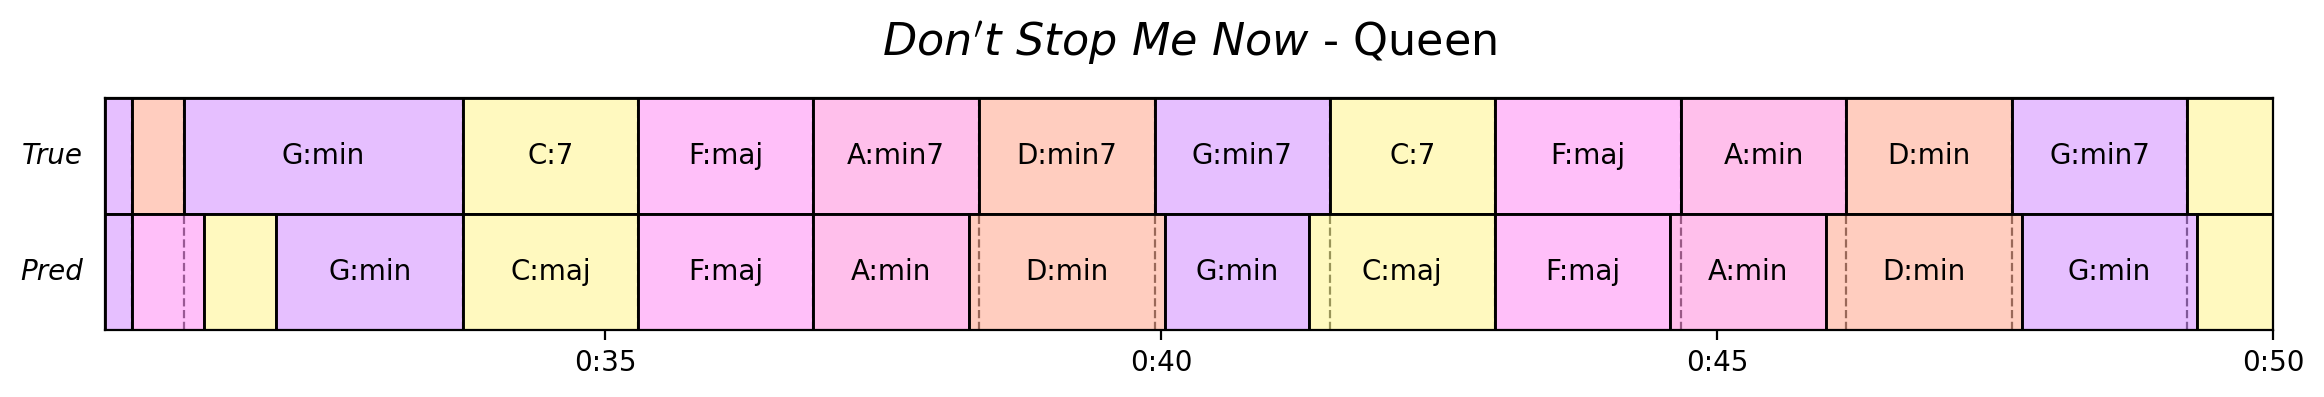

In [108]:
plot_chord_block(
    {
        "True": true_chords,
        "Pred": preds,
        # "CRNN+Smoothing": preds_smooth
    },
    window=(30.5, 50),
    # window=(60, 75),
    width_per_second=0.6,
    title=r"$\it{Don't~Stop~Me~Now}$ - Queen",
    draw_chord_change_lines=True,
    save_as='dontstopmenow',
    height_per_track=0.8,
    seed=5
)

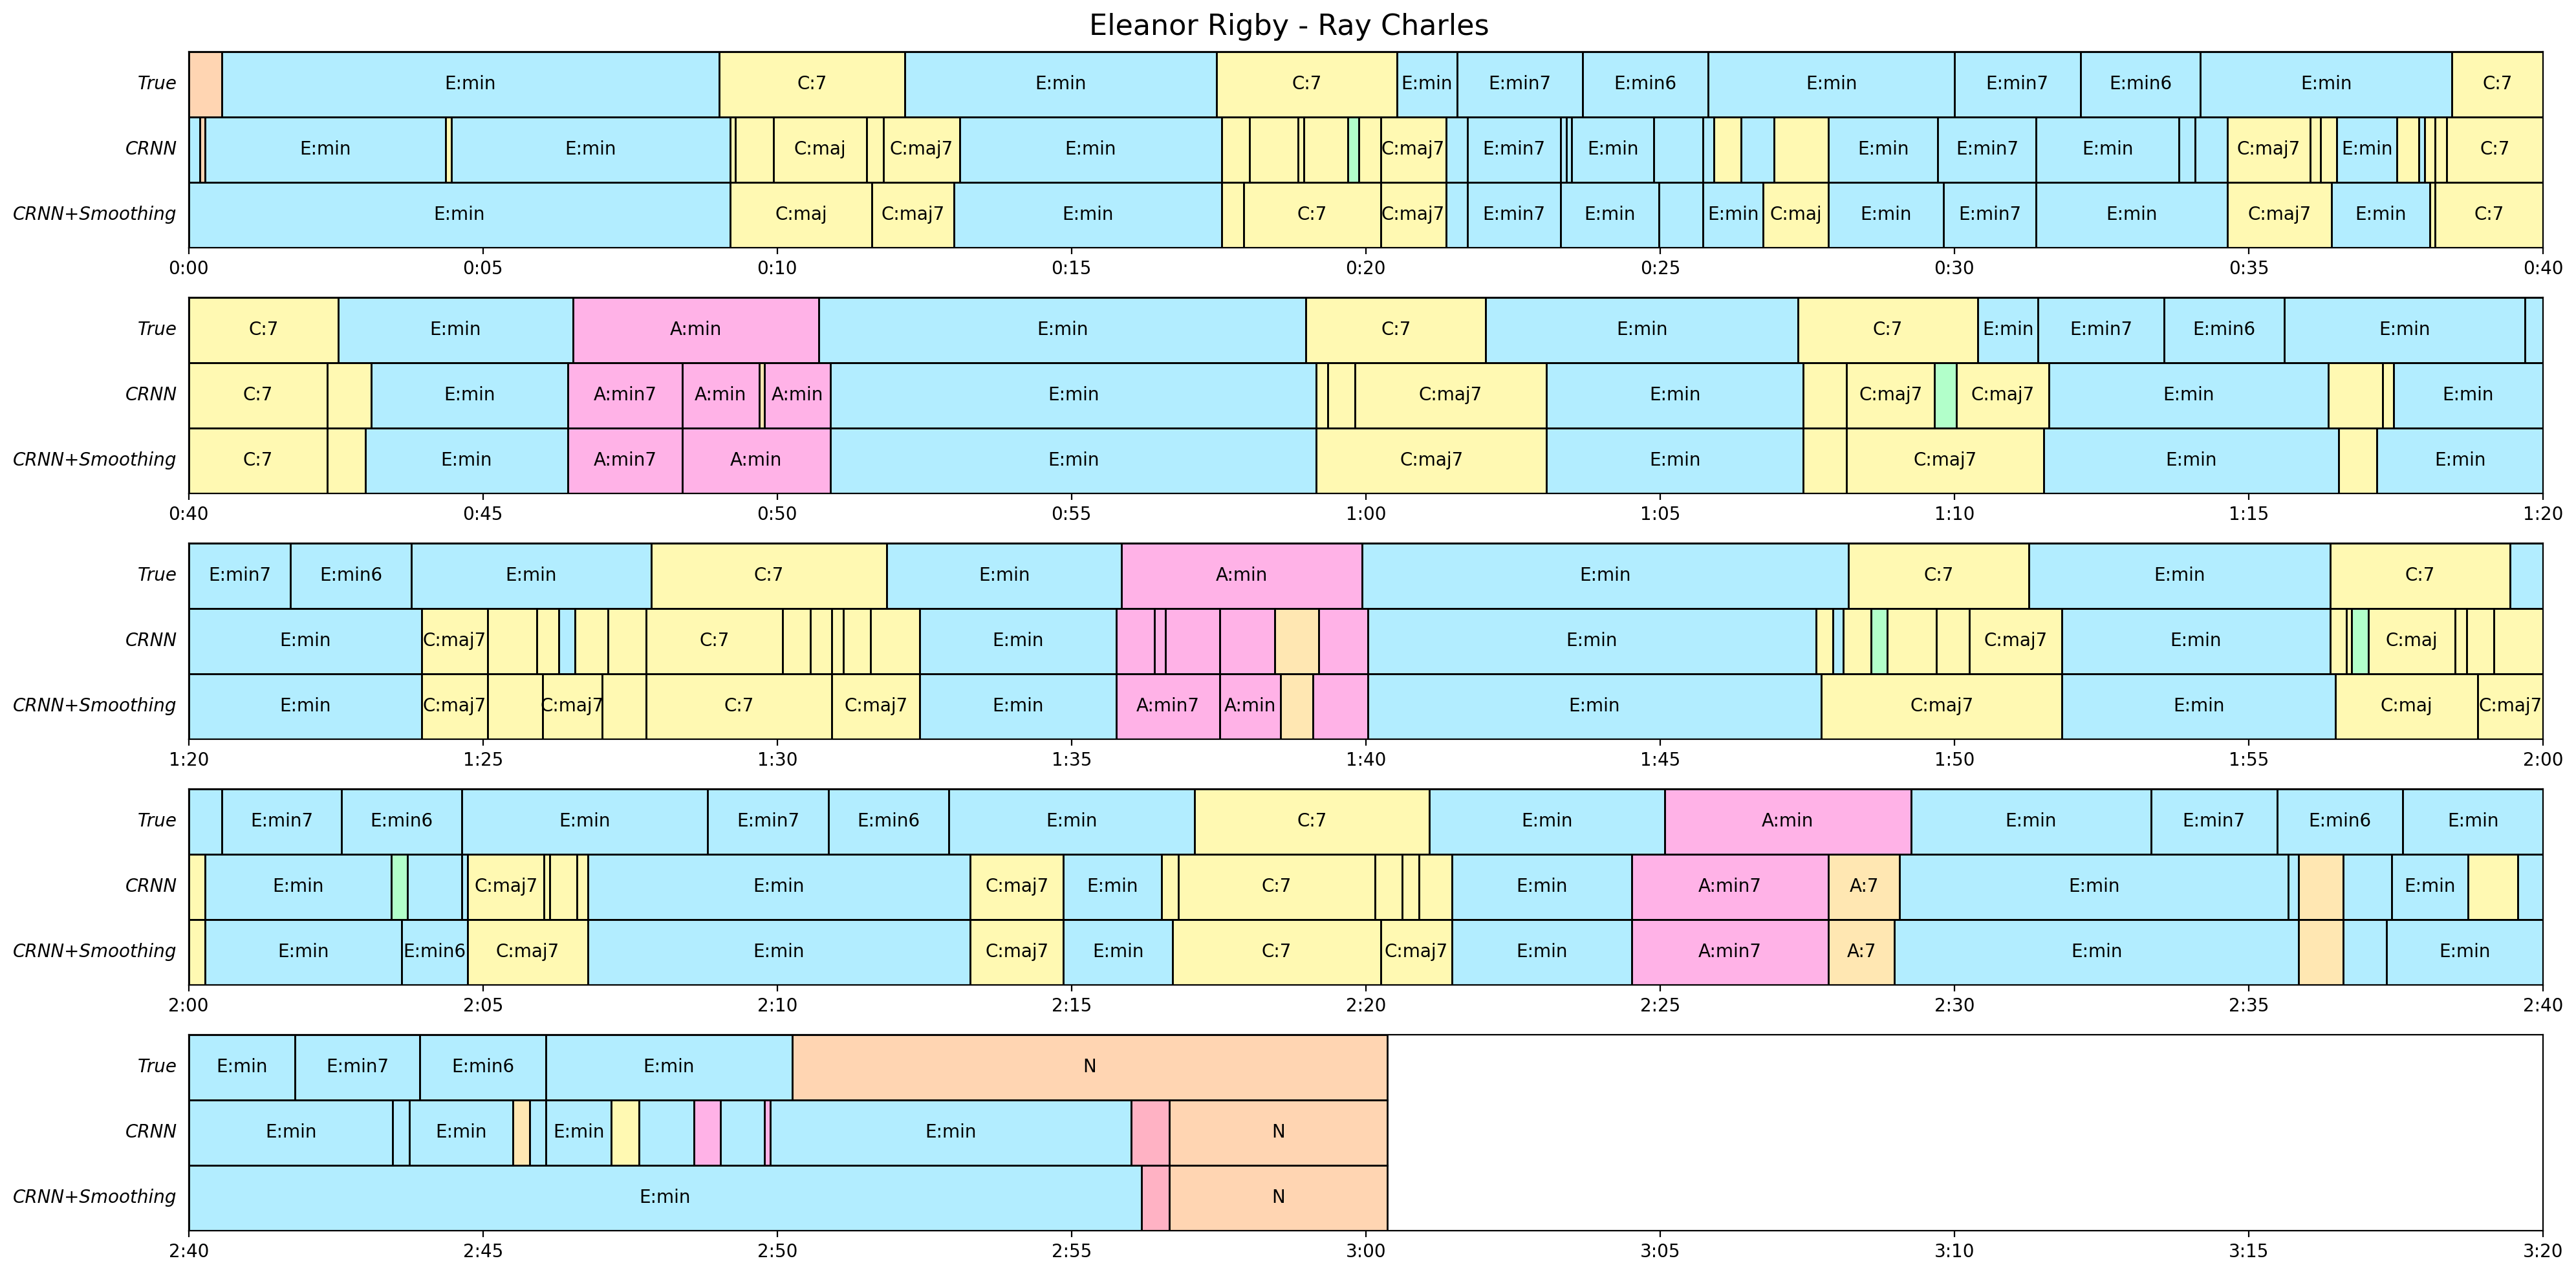

In [ ]:
plot_chord_block_wrapped(
    {
        "True": true_chords,
        "CRNN": preds,
        # "CRNN+Smoothing": preds_smooth
    },
    title="Eleanor Rigby - Ray Charles",
    max_time_per_row=40,
    width_per_second=0.5,
    seed=5
)

## Beat-Wise Comparison

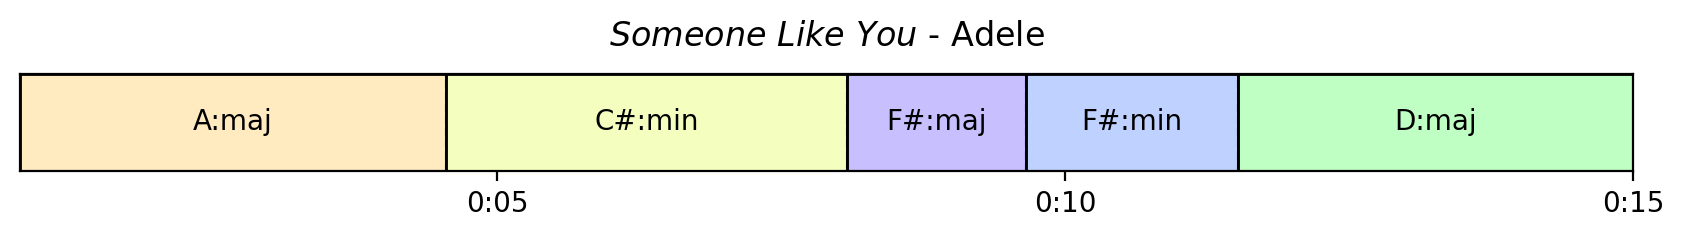

In [98]:
DIR = 'data/extras/'
filename = "someone_like_you_adele"
cqt = torch.load(f"{DIR}/cache/4096/cqts/{filename}.pt", weights_only=True)
preds = model.predict(cqt.unsqueeze(0).to(device)).squeeze()

# Visualize
plot_chord_block(
    {
        # "True": true_chords,
        "": preds,
    },
    window=(0.8, 15),
    width_per_second=0.6,
    title=r"$\it{Someone~Like~You}$ - Adele",
    draw_chord_change_lines=True,
    save_as='someone_like_you_chord',
    fsize=12,
    title_pad=10,
    height_per_track=0.8,
    seed=5
)

In [249]:
model_beats = get_model(
    exp_dir="beatwise_sampling/beat_interval_1",
    # exp_dir="hparams_random/segment_length_28_layers_1_hidden_size_201",
    hmm=False,
    device=device,
)
ds = FullChordDataset(input_dir='data/extras', filenames=[filename], dev_mode=True, beat_wise_resample=True)
preds = model_beats.predict(ds[0][0].unsqueeze(0).to(device)).squeeze()
preds_chords = [id_to_chord_map[c.item()] for c in preds]

In [250]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math

def render_chord_chart(
    chords,
    meter_numerator=4,
    chords_per_beat=1,
    bar_width=4.8,
    start_bar=1,
    height=0.4,
    end_bar=None,
    save_as: str = None,
    hadj: float = 0.0
):
    # 1) Skip leading 'N's
    chords = chords.copy()
    while chords and chords[0] == 'N':
        chords.pop(0)

    # 2) Compute total slots & bars
    slots_per_bar = meter_numerator * chords_per_beat
    total_chords  = len(chords)
    total_bars    = math.ceil(total_chords / slots_per_bar)

    # 3) Pad out to a full final bar
    total_slots = total_bars * slots_per_bar
    chords += [''] * (total_slots - total_chords)

    # 4) Clamp start/end
    start_bar = max(1, start_bar)
    end_bar   = total_bars if end_bar is None else min(end_bar, total_bars)
    if start_bar > end_bar:
        raise ValueError("start_bar must be ≤ end_bar")

    # 5) Slice chords for display
    start_idx      = (start_bar - 1) * slots_per_bar
    end_idx        = end_bar      * slots_per_bar
    display_chords = chords[start_idx:end_idx]

    # 6) Compute display dims
    display_bars  = end_bar - start_bar + 1
    slot_width    = bar_width / slots_per_bar
    total_width   = display_bars * bar_width
    fig_h         = height

    fig, ax = plt.subplots(figsize=(total_width, fig_h))  # tight vertical fit
    ax.set_ylim(0.8, 1.2) 
    pad = 0.01 * total_width
    ax.set_xlim(-pad, total_width + pad)                            # match the exact drawing range
    ax.axis('off')

    # Replace tight_layout with direct adjustment
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1)

    # 8) Draw bar boundaries (with clip_on=False so edges stay full thickness)
    for b in range(display_bars + 1):
        x = b * bar_width
        ax.vlines(
            x, 0.8, 1.2,
            lw=1.5, color='black',
            clip_on=False
        )

    # 9) Draw chord slots & suppress repeats
    box_w      = slot_width * 0.8
    pad        = (slot_width - box_w) / 2
    prev_chord = None

    for i, chord in enumerate(display_chords):
        x0 = i * slot_width + pad
        ax.add_patch(Rectangle((x0, 0.8), box_w, 0.4, facecolor='white'))
        if chord and chord != prev_chord:
            ax.text(
                x0 + box_w/2 + hadj, 1.0, chord,
                ha='center', va='center',
                fontsize=10, fontfamily='monospace'
            )
        prev_chord = chord

    plt.tight_layout()
    if save_as is not None:
        plt.savefig(f'./thesis/figures/{save_as}.png', dpi=200, bbox_inches='tight')
    plt.show()


/var/folders/wv/rkgyh65d1jx0nzbn07gn8f380000gn/T/ipykernel_45311/3947576776.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


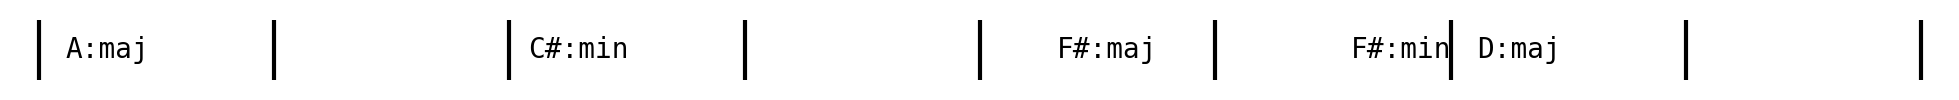

In [251]:
render_chord_chart(
    preds_chords,
    meter_numerator=4,
    chords_per_beat=1,
    bar_width=1.2, 
    start_bar=1,
    end_bar=8,
    hadj=0.2,
    height=0.3,
    save_as='someone_like_you_chord_chart',
)

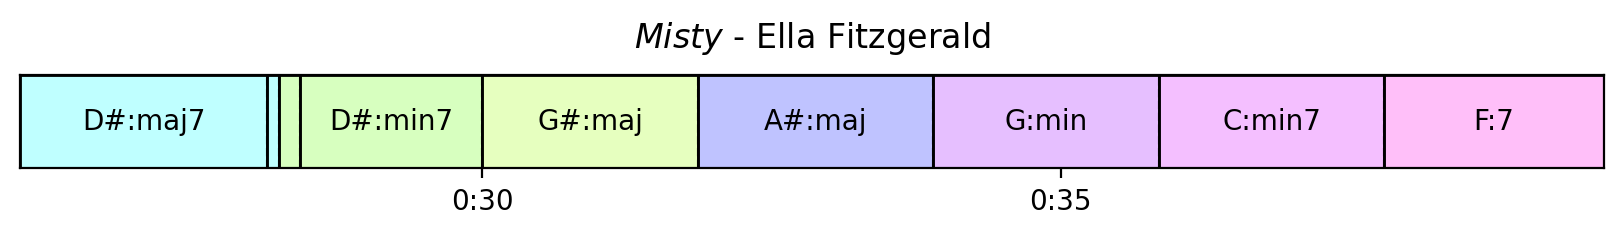

In [99]:
DIR = 'data/extras/'
filename = "misty_ella_fitzgerald"
cqt = torch.load(f"{DIR}/cache/4096/cqts/{filename}.pt", weights_only=True)
preds = model.predict(cqt.unsqueeze(0).to(device)).squeeze()

# Visualize
plot_chord_block(
    {
        # "True": true_chords,
        "": preds,
    },
    window=(26, 39.7),
    width_per_second=0.6,
    title=r"$\it{Misty}$ - Ella Fitzgerald",
    draw_chord_change_lines=True,
    save_as='misty_chord_plot',
    height_per_track=0.8,
    fsize=12,
    title_pad=10,
    seed=5
)

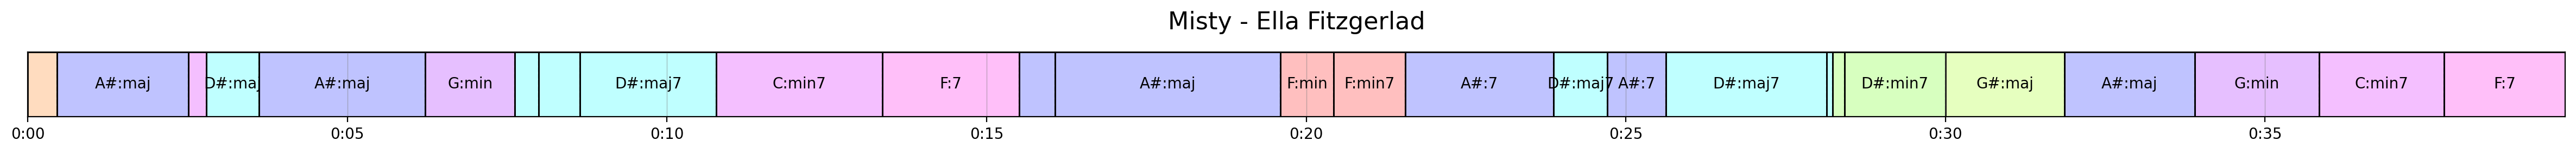

In [269]:
plot_chord_block(
    {
        # "True": true_chords,
        "": preds,
    },
    window=(0, 39.7),
    width_per_second=0.6,
    title="Misty - Ella Fitzgerlad",
    draw_chord_change_lines=True,
    # save_as='misty_chord_chart',
    seed=5
)

In [261]:
model_beats = get_model(
    # exp_dir="beatwise_sampling/beat_interval_1",
    exp_dir="final_experiments/beat_wise_sampling",
    # exp_dir="hparams_random/segment_length_28_layers_1_hidden_size_201",
    hmm=False,
    device=device,
)
ds = FullChordDataset(input_dir='data/extras', filenames=[filename], dev_mode=True, beat_wise_resample=True)
preds = model_beats.predict(ds[0][0].unsqueeze(0).to(device)).squeeze()
preds_chords = [id_to_chord_map[c.item()] for c in preds]

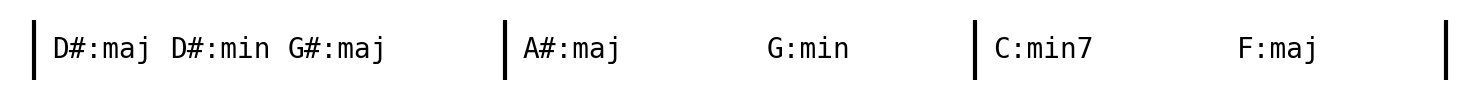

In [278]:
render_chord_chart(
    preds_chords,
    meter_numerator=4,
    chords_per_beat=1,
    bar_width=2.5,  
    start_bar=8,
    end_bar=10,
    hadj=0.05,
    height=0.6,
    save_as='misty_chord_chart',
)